### Notebook Overview: Txn Classification – RF (w/o HP Tuning)

This supplementary notebook develops a Random Forest classifier without hyperparameter tuning to classify Bitcoin transactions from the Elliptic++ dataset as either licit or illicit. It provides a non-linear baseline model that captures complex feature interactions and serves as a direct performance comparison to the untuned logistic regression model.  

**Purpose**  
The purpose of this notebook is to establish the performance of an unoptimised Random Forest model as a baseline for ensemble methods. Unlike logistic regression, Random Forest can naturally handle non-linear relationships and feature interactions without extensive preprocessing or feature scaling. This implementation assesses the model’s out-of-the-box performance before any tuning of parameters such as tree depth, learning rate, or feature sampling.  

**Key Steps**  
- Import labelled transaction data from the Elliptic++ dataset stored in BigQuery.  
- Split the data into training and testing sets, maintaining class balance.  
- Initialise a Random Forest classifier using default scikit-learn parameters.  
- Train the model on the labelled dataset to predict licit and illicit transactions.  
- Evaluate model performance using accuracy, precision, recall, F1-score, and ROC-AUC metrics.  
- Compare the untuned Random Forest model to both untuned and tuned logistic regression models.  
- Export model predictions, probability scores, and feature importance rankings to BigQuery for analysis.  

**Outcome**  
The untuned Random Forest model provides a strong baseline, outperforming the untuned logistic regression model across most metrics due to its ability to capture non-linear relationships between features. It achieves high precision and overall accuracy but slightly underperforms in recall, indicating that while it effectively identifies licit transactions, some illicit cases remain undetected. This result confirms that Random Forest models are robust even without tuning, but further optimisation is needed to improve sensitivity to illicit activity.  

**Context and Attribution**  
This notebook forms part of the technical work developed in support of the research thesis titled:  
_“Detection, Ranking and Visualisation of Money Laundering Networks on the Bitcoin Blockchain”_  
by Jennifer Payne (RMIT University).  

GitHub Repository: [https://github.com/majorpayne-2021/rmit_master_thesis](https://github.com/majorpayne-2021/rmit_master_thesis)  
Elliptic++ Dataset Source: [https://github.com/git-disl/EllipticPlusPlus](https://github.com/git-disl/EllipticPlusPlus)


In [ ]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import math

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Txn Classification Classes & Modules
--------------


In [ ]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_classification.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_classification"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [ ]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - KFold
  - LogisticRegression
  - RandomForestClassifier
  - SimpleImputer
  - StandardScaler
  - build_model
  - model_preprocessing
  - model_reporting


In [ ]:
# Instantiate the classes
preprocessor = module.model_preprocessing()
build_model = module.build_model()
report = module.model_reporting()

--------------
##### Read in Datasets
--------------


In [ ]:
# Read in enhanced txn edgelist table from BigQuery
%%bigquery df_txn_features_clean
select * from `extreme-torch-467913-m6.txn.txn_features_clean`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(df_txn_features_clean.shape)
df_txn_features_clean.dropna().head()

(203769, 198)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile
275,148886499,39,3,Unknown,-0.1719,-0.0696,1.0186,-0.1220,-0.0637,-0.1130,-0.0616,-0.1625,-0.1683,-0.0497,-0.1648,-0.0287,-0.0354,-0.0632,-0.0133,-0.0410,-0.1700,-0.1729,-0.1736,-0.2433,-0.2435,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4140,-0.4884,-0.2326,-0.4676,0.0488,0.0530,

In [ ]:
dataset = df_txn_features_clean

-------------------
##### Handle Missing Values
-------------------

In [ ]:
# Handle missing values first
dataset_imputed = preprocessor.handle_missing_values(dataset, ignore_cols = ['txId', 'Time step', 'class_label', 'class'])


===== Missing Value Summary Before Imputation =====
in_txs_degree                965
out_txs_degree               965
total_BTC                    965
fees                         965
size                         965
num_input_addresses          965
num_output_addresses         965
in_BTC_min                   965
in_BTC_max                   965
in_BTC_mean                  965
in_BTC_median                965
in_BTC_total                 965
out_BTC_min                  965
out_BTC_max                  965
out_BTC_mean                 965
out_BTC_median               965
out_BTC_total                965
in_out_ratio                 965
input_output_ratio           965
BTC_dispersion               965
high_fees_flag               965
micro_txn_flag               965
txn_density                  965
fees_per_byte                965
fees_ratio                   965
fees_per_input               965
rounded_amount_flag          965
input_address_percentile     965
output_address_percenti

-------------------
##### Split into Training/Validation and Test Sets
-------------------

In [ ]:
# Preprocess data - split into training/validation and test (blind) datasets.
X, y, X_test, y_test, time_step = preprocessor.split_training_test_data(dataset_imputed)


===== Dataset Summary =====
Total Dataset Size: 203,769

Training/Validation Set: 46,564 (22.9%)
0.0000    42,019 (90.2%)
1.0000    4,545 (9.8%)
Total Training/Validation Size: 46,564
Rows with Missing Values in Training/Validation: 0

Test Set: 157,205 (77.1%)
nan    157,205 (100.0%)
Total Test Size: 157,205
Rows with Missing Values in Test Set: 0


In [ ]:
# Extract indices for Train/Val and Test
train_val_indices = X.index  # Indices of training/validation set
test_indices = X_test.index  # Indices of test set

In [ ]:
# Apply function to label the dataset
dataset_imputed = preprocessor.label_train_val_test(dataset_imputed, train_val_indices, test_indices)

# Verify Labels
class_counts = dataset_imputed.groupby(['data_split', 'class_label']).size().unstack(fill_value=0)
class_counts

class_label,Illicit,Licit,Unknown
data_split,,,
Test,0,0,157205
Train/Val,4545,42019,0


-------------------
##### Training and Validation using Cross-Fold on Temporal Data
-------------------

In [ ]:
timestep_field = "Time step"

drop_training_cols = ['txId', 'Time step', 'class', 'class_label', 'data_split', 'training_label', 'pred_proba']

columns_to_normalize = [
    col for col in dataset.columns
    if col not in drop_training_cols and not col.startswith("Local_feature_") and not col.startswith("Aggregate_feature_")
    ]

print(columns_to_normalize)

['in_txs_degree', 'out_txs_degree', 'total_BTC', 'fees', 'size', 'num_input_addresses', 'num_output_addresses', 'in_BTC_min', 'in_BTC_max', 'in_BTC_mean', 'in_BTC_median', 'in_BTC_total', 'out_BTC_min', 'out_BTC_max', 'out_BTC_mean', 'out_BTC_median', 'out_BTC_total', 'in_out_ratio', 'input_output_ratio', 'BTC_dispersion', 'high_fees_flag', 'micro_txn_flag', 'txn_density', 'fees_per_byte', 'fees_ratio', 'fees_per_input', 'rounded_amount_flag', 'input_address_percentile', 'output_address_percentile']


In [ ]:
data_split_field = "data_split"
valid_splits = ['Train/Val']
obs_size = 30000  # Number of observations per fold
train_ratio = 0.5
threshold = 0.5
num_folds = 10
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

Processing Fold 1: 30000 observations...


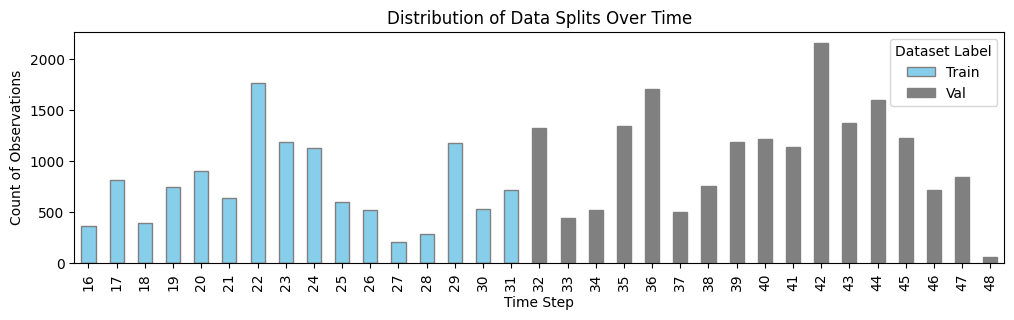

Processing Fold 2: 30000 observations...


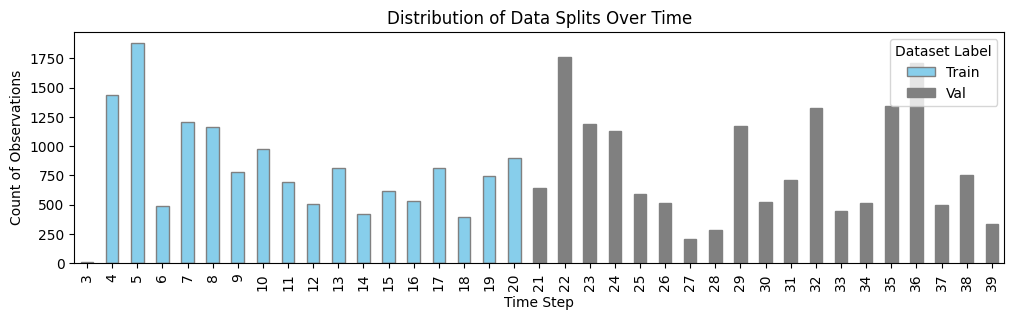

Processing Fold 3: 30000 observations...


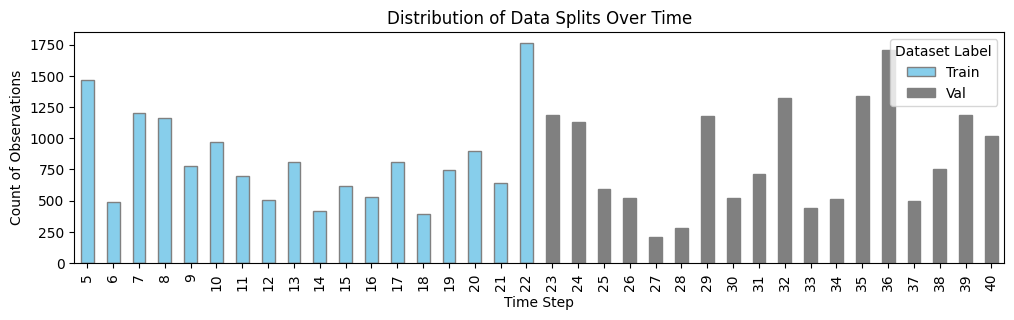

Processing Fold 4: 30000 observations...


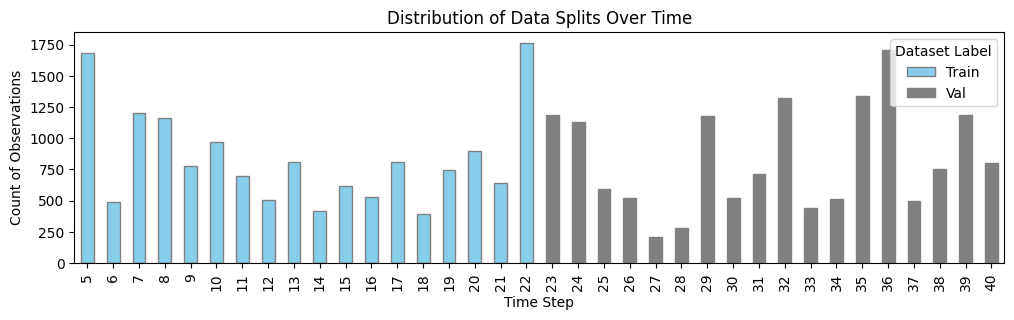

Processing Fold 5: 30000 observations...


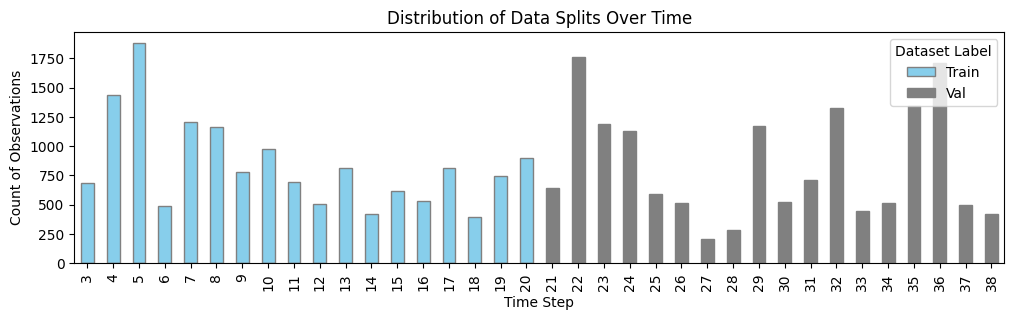

Processing Fold 6: 30000 observations...


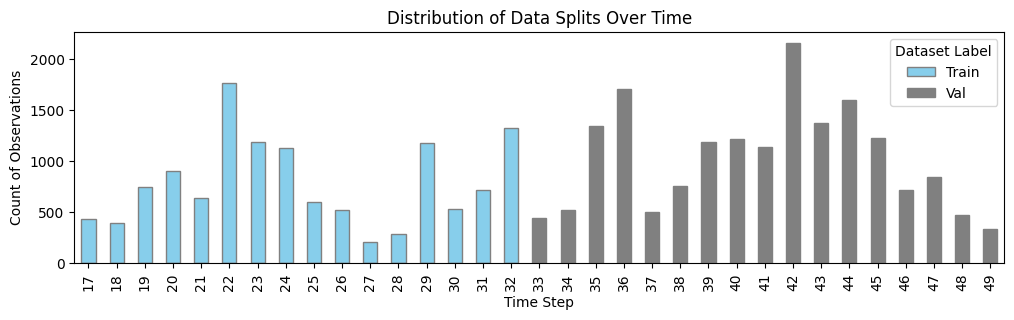

Processing Fold 7: 30000 observations...


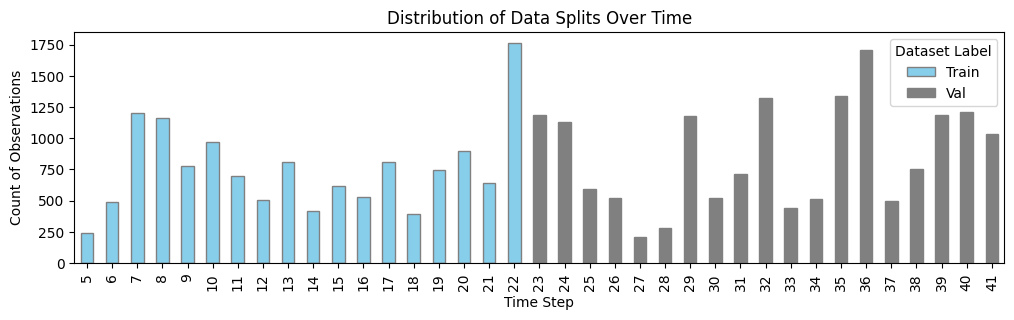

Processing Fold 8: 30000 observations...


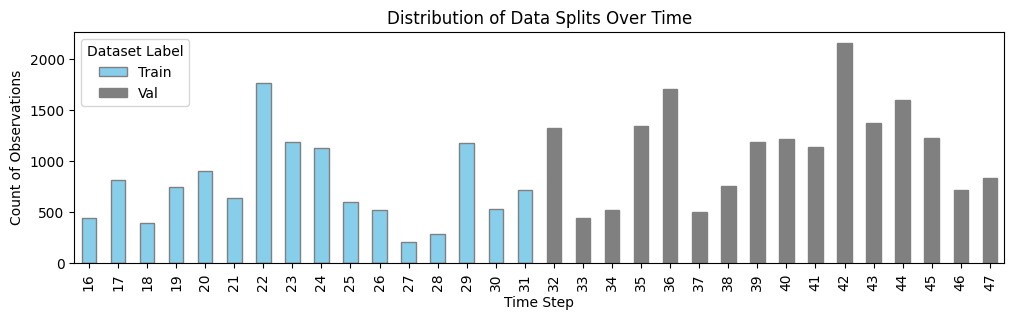

Processing Fold 9: 30000 observations...


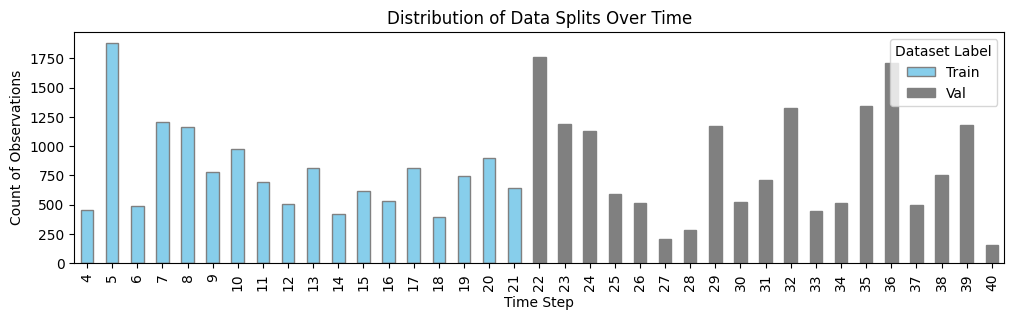

Processing Fold 10: 30000 observations...


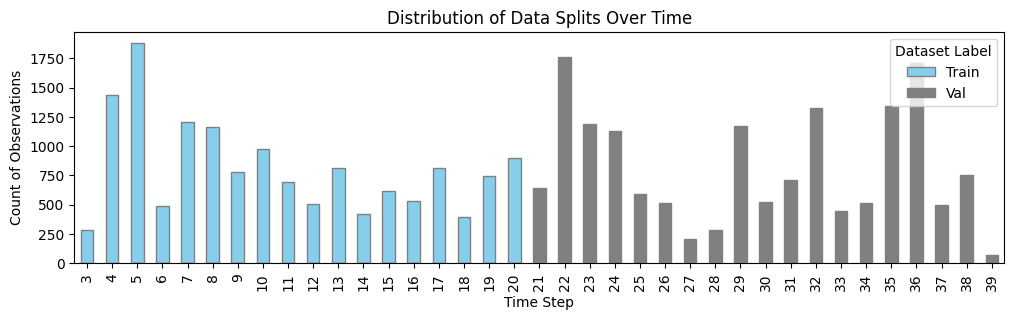

In [ ]:
summary_df, trained_models, scalers, fold_indices_dict = build_model.run_cross_validation(
    input_df=dataset_imputed,
    timestep_field=timestep_field,
    drop_training_cols=drop_training_cols,
    columns_to_normalize=columns_to_normalize,
    data_split_field=data_split_field,
    valid_splits=valid_splits,
    model = model,
    obs_size=obs_size,
    train_ratio=train_ratio,
    threshold=threshold,
    num_folds=num_folds
)

In [ ]:
summary_df

,Fold,Threshold,Total Size,Training Size,Validation Size,Class 0 Size,Class 1 Size,Train Class Distribution,Val Class Distribution,Min Time Step,Max Time Step,Accuracy,Recall,Precision,F1-Score,AUC-ROC,Gini Score,True Positive,True Negative,False Positive,False Negative
0,Fold 1,0.5000,30000,11936,18064,26731,3269,"{0.0: 10067, 1.0: 1869}","{0.0: 16664, 1.0: 1400}",16,48,0.9881,0.8935,0.9973,0.9426,0.9870,0.9740,2921,26723,8,348
1,Fold 2,0.5000,30000,14357,15643,26180,3820,"{0.0: 12632, 1.0: 1725}","{0.0: 13548, 1.0: 2095}",3,39,0.9741,0.8024,0.9926,0.8874,0.9406,0.8813,3065,26157,23,755
2,Fold 3,0.5000,30000,14892,15108,26069,3931,"{0.0: 12940, 1.0: 1952}","{0.0: 13129, 1.0: 1979}",5,40,0.9736,0.8023,0.9950,0.8883,0.9218,0.8436,3154,26053,16,777
3,Fold 4,0.5000,30000,15108,14892,26091,3909,"{0.0: 13155, 1.0: 1953}","{0.0: 12936, 1.0: 1956}",5,40,0.9740,0.8046,0.9949,0.8897,0.9238,0.8476,3145,26075,16,764
4,Fold 5,0.5000,30000,15028,14972,26263,3737,"{0.0: 13298, 1.0: 1730}","{0.0: 12965, 1.0: 2007}",3,38,0.9742,0.7993,0.9924,0.8854,0.9408,0.8816,2987,26240,23,750
5,Fold 6,0.5000,30000,12518,17482,26804,3196,"{0.0: 10442, 1.0: 2076}","{0.0: 16362, 1.0: 1120}",17,49,0.9883,0.8933,0.9965,0.9421,0.9811,0.9622,2855,26794,10,341
6,Fold 7,0.5000,30000,13666,16334,25947,4053,"{0.0: 11720, 1.0: 1946}","{0.0: 14227, 1.0: 2107}",5,41,0.9724,0.7997,0.9951,0.8867,0.9229,0.8457,3241,25931,16,812
7,Fold 8,0.5000,30000,12013,17987,26720,3280,"{0.0: 10126, 1.0: 1887}","{0.0: 16594, 1.0: 1393}",16,47,0.9886,0.8985,0.9973,0.9453,0.9877,0.9755,2947,26712,8,333
8,Fold 9,0.5000,30000,13999,16001,26151,3849,"{0.0: 12198, 1.0: 1801}","{0.0: 13953, 1.0: 2048}",4,40,0.9743,0.8046,0.9942,0.8894,0.9145,0.8290,3097,26133,18,752
9,Fold 10,0.5000,30000,14627,15373,26210,3790,"{0.0: 12900, 1.0: 1727}","{0.0: 13310, 1.0: 2063}",3,39,0.9740,0.8003,0.9928,0.8862,0.9481,0.8962,3033,26188,22,757


-------------------
##### Select Best Model from Cross-Fold Validation
-------------------

In [ ]:
# Assuming cross_fold_summary, saved_models, and saved_scalers dictionaries are defined
best_model, best_scaler = build_model.select_best_model_and_scaler(cross_fold_summary = summary_df, saved_models = trained_models, saved_scalers = scalers, top_n = 5)

Top Models Ranked:
1. Fold 8 - Gini Score: 0.9755, Recall: 0.8985, Accuracy: 0.9886, AUC-ROC: 0.9877, Precision: 0.9973, F1-Score: 0.9453
2. Fold 1 - Gini Score: 0.9740, Recall: 0.8935, Accuracy: 0.9881, AUC-ROC: 0.9870, Precision: 0.9973, F1-Score: 0.9426
3. Fold 6 - Gini Score: 0.9622, Recall: 0.8933, Accuracy: 0.9883, AUC-ROC: 0.9811, Precision: 0.9965, F1-Score: 0.9421
4. Fold 10 - Gini Score: 0.8962, Recall: 0.8003, Accuracy: 0.9740, AUC-ROC: 0.9481, Precision: 0.9928, F1-Score: 0.8862
5. Fold 5 - Gini Score: 0.8816, Recall: 0.7993, Accuracy: 0.9742, AUC-ROC: 0.9408, Precision: 0.9924, F1-Score: 0.8854

Best Model Selected: Fold 8


In [ ]:
# Get feature names used during training
#print(best_model.feature_names_in_)

Load model and scaler, trained on training data during cross-fold

In [ ]:
# OR manually select model and scaler
#best_model = trained_models['Fold 4']
#best_scaler = scalers['Fold 4']

-------------------
##### Apply Best Model to Training and Validation Data
-------------------

Apply scaler to full dataset

In [ ]:
test_normalize_cols = columns_to_normalize
print(test_normalize_cols)

['in_txs_degree', 'out_txs_degree', 'total_BTC', 'fees', 'size', 'num_input_addresses', 'num_output_addresses', 'in_BTC_min', 'in_BTC_max', 'in_BTC_mean', 'in_BTC_median', 'in_BTC_total', 'out_BTC_min', 'out_BTC_max', 'out_BTC_mean', 'out_BTC_median', 'out_BTC_total', 'in_out_ratio', 'input_output_ratio', 'BTC_dispersion', 'high_fees_flag', 'micro_txn_flag', 'txn_density', 'fees_per_byte', 'fees_ratio', 'fees_per_input', 'rounded_amount_flag', 'input_address_percentile', 'output_address_percentile']


In [ ]:
# Make a copy of the dataset to avoid modifying the original
dataset_bestmodel = dataset_imputed[dataset_imputed['data_split'] == 'Train/Val'].copy()

# Apply the fitted scaler from Fold 8 to the full dataset
dataset_bestmodel[test_normalize_cols] = best_scaler.transform(dataset_bestmodel[test_normalize_cols])

In [ ]:
dataset_bestmodel.head(3)

,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,data_split
2,152338737,39,0.0000,Licit,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4139,-0.4883,-0.2326,-0.4675,0.048

Apply the model for predictions

In [ ]:
# Get the exact features used during training
trained_features = best_model.feature_names_in_

# Drop unnecessary fields before prediction
dataset_bestmodel_pred = dataset_bestmodel[trained_features].copy()

# Generate predictions using the trained model
dataset_bestmodel_pred['pred_proba'] = best_model.predict_proba(dataset_bestmodel_pred)[:, 1]

In [ ]:
dataset_bestmodel_pred.head()

,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_proba
2,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4139,-0.4883,-0.2326,-0.4675,0.0488,0.0530,-0.0391,-0.1729,-0.1631,-0.1609,0.9235,0.9230,-0.0

In [ ]:
# Map the predicted probability column
dataset_bestmodel['pred_proba'] = dataset_bestmodel_pred['pred_proba']

In [ ]:
# Build pred bins
list_bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
dataset_bestmodel_pred = preprocessor.build_bins_manually(input_df = dataset_bestmodel
                                                          , field_risk_score='pred_proba'
                                                          , list_bin_thresholds=list_bins)

In [ ]:
print(dataset_bestmodel.shape)
dataset_bestmodel.head()

(46564, 203)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,data_split,pred_proba,pred_bin,pred_bin_LOWERB,pred_bin_UPPERB
2,152338737,39,0.0000,Licit,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359

-------------------
##### Performance at different thresholds (confusion matrix)
-------------------

In [ ]:
# Build binned pred report
evaluation_report = report.build_binned_pred_report(dataset_bestmodel)
evaluation_report

,Illicit,Licit,TOTAL,Illicit_PCT,Licit_PCT,TOTAL_PCT,Illicit_CUMPCT,Licit_CUMPCT,TOTAL_CUMPCT,Illicit_Licit_ODDS,Illicit_CONVERSION
0.0-0.1,534.0000,36186.0000,36720.0000,0.1170,0.8610,0.7890,0.1170,0.8610,0.7890,0.0100,0.0100
0.1-0.2,258.0000,4607.0000,4865.0000,0.0570,0.1100,0.1040,0.1740,0.9710,0.8930,0.0600,0.0500
0.2-0.3,210.0000,1139.0000,1349.0000,0.0460,0.0270,0.0290,0.2200,0.9980,0.9220,0.1800,0.1600
0.3-0.4,366.0000,78.0000,444.0000,0.0810,0.0020,0.0100,0.3010,1.0000,0.9320,4.6900,0.8200
0.4-0.5,1986.0000,9.0000,1995.0000,0.4370,0.0000,0.0430,0.7380,1.0000,0.9740,220.6700,1.0000
0.5-0.6,1162.0000,0.0000,1162.0000,0.2560,0.0000,0.0250,0.9940,1.0000,0.9990,1162.0000,1.0000
0.6-0.7,28.0000,0.0000,28.0000,0.0060,0.0000,0.0010,1.0000,1.0000,1.0000,28.0000,1.0000
0.7-0.8,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Total,4545.0000,42019.0000,46564.0000,1.0000,1.0000,1.0010,1.0000,1.0000,1.0000,0.1082,0.0976


In [ ]:
# See confusion matrix at different thresholds
cm_report, cm_results_df = report.calculate_cm_performance(dataset_bestmodel,
                                                    field_class_binary='class',
                                                    field_pred_proba='pred_proba')

In [ ]:
cm_report

,ACCURACY,RECALL,PRECISION,F1,TRUE_POSITIVE,TRUE_NEGATIVE,FALSE_POSITIVE,FALSE_NEGATIVE,TOTAL
THRESHOLD,,,,,,,,,
0.1000,0.8600,0.8800,0.4100,0.5600,4011,36186,5833,534,46564
0.2000,0.9600,0.8300,0.7500,0.7900,3753,40793,1226,792,46564
0.3000,0.9800,0.7800,0.9800,0.8700,3543,41932,87,1002,46564
0.4000,0.9700,0.7000,1.0000,0.8200,3177,42010,9,1368,46564
0.5000,0.9300,0.2600,1.0000,0.4200,1191,42019,0,3354,46564
0.6000,0.9000,0.0100,1.0000,0.0100,29,42019,0,4516,46564
0.7000,0.9000,0.0000,1.0000,0.0000,1,42019,0,4544,46564
0.8000,0.9000,0.0000,0.0000,0.0000,0,42019,0,4545,46564


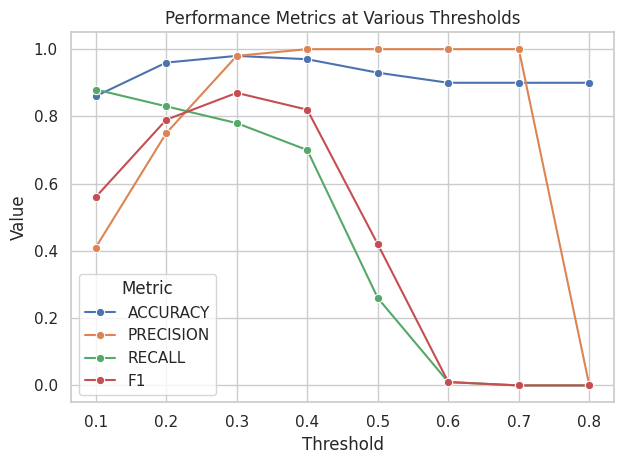

In [ ]:
report.plot_cm_metrics(input_df=cm_results_df,
                plot_x_axis='THRESHOLD',
                plot_value='VALUE',
                classes='METRIC')

# threshold of 0.3 is an appropriate threshold as it's a good balance between accuracy and recall, given imbalanced dataset.

In [ ]:
# Apply the threshold to create the pred_class. Returns True (1) or False (0) based on the threshold.
illicit_threshold = 0.4
dataset_bestmodel['pred_class'] = (dataset_bestmodel['pred_proba'] >= illicit_threshold).astype(int)

# Map numeric classes to labels
dataset_bestmodel['pred_class_label'] = dataset_bestmodel['pred_class'].map({1: "Illicit", 0: "Licit"})

In [ ]:
# Evaluate model performance
report.evaluate_final_model(y_true = dataset_bestmodel['class'], y_pred = dataset_bestmodel['pred_class'], label = f"Best Model w {illicit_threshold:.2f} Threshold")

,Label,Total Size,Accuracy,Recall,Precision,F1-Score,AUC-ROC,Gini Score,True Positive,True Negative,False Positive,False Negative
0,Best Model w 0.40 Threshold,46564,0.9704,0.6990,0.9972,0.8219,0.8494,0.6988,3177,42010,9,1368


-------------------
##### Blind Test - Label Unknown Txn Classes
-------------------

In [ ]:
test_normalize_cols = columns_to_normalize

# Make a copy of the dataset to avoid modifying the original
dataset_final_pred = dataset_imputed.copy()

# Apply the fitted scaler to the full dataset
dataset_final_pred[test_normalize_cols] = best_scaler.transform(dataset_final_pred[test_normalize_cols])

In [ ]:
# Get the exact features used during training
trained_features = best_model.feature_names_in_

# Drop unnecessary fields before prediction
dataset_final_pred = dataset_final_pred[trained_features].copy()

# Generate predictions using the trained model
dataset_final_pred['pred_proba'] = best_model.predict_proba(dataset_final_pred)[:, 1]

In [ ]:
# Map the predicted probability column
dataset_final = df_txn_features_clean.copy()

# Apply prediction model label to final dataset
dataset_final['pred_model'] = 'Random Forest'

# Apply prediction model label to final dataset
dataset_final['pred_model_threshold'] = 0.3

# Apply prediction to dataset final
dataset_final['pred_proba'] = dataset_final_pred['pred_proba']

# Apply the threshold to create the pred_class. Returns True (1) or False (0) based on the threshold.
dataset_final['pred_class'] = (dataset_final['pred_proba'] >= 0.3).astype(int)

# Map numeric classes to labels
dataset_final['pred_class_label'] = dataset_final['pred_class'].map({1: "Illicit", 0: "Licit"})

In [ ]:
# If actual 'class' is 'licit' or 'illicit', keep it; otherwise, use 'pred_class'
dataset_final['final_class'] = np.where(dataset_final['class'].isin([0, 1]),
                                        dataset_final['class'],
                                        dataset_final['pred_class'])

dataset_final['final_class_label'] = np.where(dataset_final['class_label'].isin(['Licit', 'Illicit']),
                                        dataset_final['class_label'],
                                        dataset_final['pred_class_label'])

In [ ]:
print(dataset_final.shape)
dataset_final.head(3)

(203769, 205)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_model,pred_model_threshold,pred_proba,pred_class,pred_class_label,final_class,final_class_label
0,30549576,8,3,Unknown,-0.1700,-0.1805,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.1606,-0.1665,-0.0497,-0.1629,-0.0287,-0.0354,-0.0430,-0.0133,-0.0542,-0.1684,-0.1700,-0.1728,-1.3737,-1.3715,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.

Check predictions

In [ ]:
# Calculate the count of pred_class_label grouped by class_label
pred_v_actual = dataset_final.groupby("class_label")["pred_class_label"].value_counts().unstack()
pred_v_actual

pred_class_label,Illicit,Licit
class_label,,
Illicit,3543,1002
Licit,87,41932
Unknown,8838,148367


In [ ]:
# Calculate percentage of final_class_label within each class_label group
pred_v_actual_perc = dataset_final.groupby("class_label")["pred_class_label"].value_counts(normalize=True).unstack() * 100
pred_v_actual_perc

pred_class_label,Illicit,Licit
class_label,,
Illicit,77.9538,22.0462
Licit,0.2070,99.7930
Unknown,5.6220,94.3780


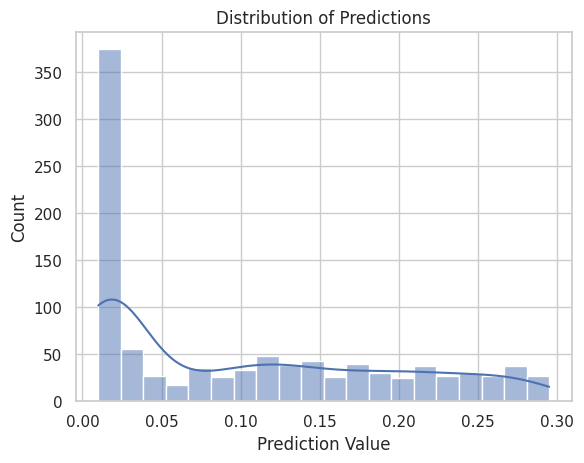

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_check = dataset_final[(dataset_final['class_label']== 'Illicit') & (dataset_final['pred_class_label']== 'Licit')]

# Example: continuous predictions
sns.histplot(df_check["pred_proba"], bins=20, kde=True)  # histogram + density curve
plt.title("Distribution of Predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Count")
plt.show()

In [ ]:
# Count occurrences of final_class_label within each class_label group
final_class_summary = dataset_final.groupby("class_label")["final_class_label"].value_counts().unstack()
final_class_summary

final_class_label,Illicit,Licit
class_label,,
Illicit,4545.0000,NaN
Licit,NaN,42019.0000
Unknown,8838.0000,148367.0000


In [ ]:
# Calculate percentage of final_class_label within each class_label group
final_class_percentage = dataset_final.groupby("class_label")["final_class_label"].value_counts(normalize=True).unstack() * 100
final_class_percentage

final_class_label,Illicit,Licit
class_label,,
Illicit,100.0000,NaN
Licit,NaN,100.0000
Unknown,5.6220,94.3780


In [ ]:
# Calculate the count of final_class_label grouped by class_label
final_class_counts = dataset_final.groupby("class_label")["final_class_label"].value_counts().unstack()

# Convert counts to column-wise percentages
final_class_percentage_column = final_class_counts.div(final_class_counts.sum(axis=0), axis=1) * 100
final_class_percentage_column

final_class_label,Illicit,Licit
class_label,,
Illicit,33.9610,NaN
Licit,NaN,22.0704
Unknown,66.0390,77.9296


In [ ]:
# Build txn final class prediction df.
dataset_class_only = dataset_final[['txId','Time step' ,'class','class_label','pred_model','pred_model_threshold','pred_proba','pred_class', 'pred_class_label', 'final_class', 'final_class_label' ]]
print(dataset_class_only.shape)
dataset_class_only.head()

(203769, 11)


,txId,Time step,class,class_label,pred_model,pred_model_threshold,pred_proba,pred_class,pred_class_label,final_class,final_class_label
0,30549576,8,3,Unknown,Random Forest,0.3000,0.1450,0,Licit,0,Licit
1,93733985,26,3,Unknown,Random Forest,0.3000,0.2300,0,Licit,0,Licit
2,152338737,39,2,Licit,Random Forest,0.3000,0.1650,0,Licit,0,Licit
3,12805211,41,3,Unknown,Random Forest,0.3000,0.1850,0,Licit,0,Licit
4,3084073,1,3,Unknown,Random Forest,0.3000,0.0850,0,Licit,0,Licit


Update edgelist with final class pred as a check

In [ ]:
# Read in address txn edgelist from BigQuery
%%bigquery df_txn_edgelist
select * from `extreme-torch-467913-m6.txn.txn_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Join txn
df_txn_edglist_class = pd.merge(df_txn_edgelist, dataset_class_only, how = 'left', left_on = 'txId1',right_on = 'txId')
df_txn_edglist_class = df_txn_edglist_class.rename(columns={'class_label': 'txId1_class'})
df_txn_edglist_class = df_txn_edglist_class.drop(columns=['txId'])

df_txn_edglist_class = pd.merge(df_txn_edglist_class, dataset_class_only[['txId','class_label']], how = 'left', left_on = 'txId2',right_on = 'txId')
df_txn_edglist_class = df_txn_edglist_class.rename(columns={'class_label': 'txId2_class'})
df_txn_edglist_class = df_txn_edglist_class.drop(columns=['txId'])
df_txn_edglist_class = df_txn_edglist_class[['txId1','txId2','txId1_class','txId2_class','Time step']]
df_txn_edglist_class.head()

,txId1,txId2,txId1_class,txId2_class,Time step
0,36186840,1076,Unknown,Unknown,48
1,288204526,3181,Licit,Licit,34
2,196542151,3321,Unknown,Unknown,1
3,18810,5473,Unknown,Unknown,48
4,3275150,6415,Unknown,Unknown,48


In [ ]:
df_txn_edglist_class = pd.merge(df_txn_edglist_class, dataset_class_only[['txId','final_class_label']], how = 'left', left_on= 'txId1', right_on= 'txId')
df_txn_edglist_class = df_txn_edglist_class.rename(columns={'final_class_label': 'txId1_class_pred'})
df_txn_edglist_class = df_txn_edglist_class.drop(columns=['txId'])

df_txn_edglist_class = pd.merge(df_txn_edglist_class, dataset_class_only[['txId','final_class_label']], how = 'left', left_on= 'txId2', right_on= 'txId')
df_txn_edglist_class = df_txn_edglist_class.rename(columns={'final_class_label': 'txId2_class_pred'})
df_txn_edglist_class = df_txn_edglist_class.drop(columns=['txId'])

df_txn_edglist_class.head()

,txId1,txId2,txId1_class,txId2_class,Time step,txId1_class_pred,txId2_class_pred
0,36186840,1076,Unknown,Unknown,48,Licit,Licit
1,288204526,3181,Licit,Licit,34,Licit,Licit
2,196542151,3321,Unknown,Unknown,1,Licit,Licit
3,18810,5473,Unknown,Unknown,48,Licit,Licit
4,3275150,6415,Unknown,Unknown,48,Licit,Licit


Random Forest with hyper parameter tuning performance is superior to logistic regression so predicted labels will be the result from the RF model.